<a href="https://colab.research.google.com/github/funkdub/Pytorch/blob/master/LeNet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('Importing ...')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets


import os
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Importing ...


使用datasets 准备数据集，并且将训练集 验证机 以及 测试集准备好。

In [2]:
# 其实就是数据增强操作,在dataloader中使用transforms
train_transforms = transforms.Compose(
[
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
]
)

test_transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
]
)

train_data = datasets.CIFAR10('data',train=True,download=True,transform=train_transforms)
test_data = datasets.CIFAR10('data',train=False,download=True,transform=test_transforms)

n_train = int(len(train_data)*0.9)
n_valid = len(train_data) - n_train

train_data,valid_data = torch.utils.data.random_split(train_data,[n_train,n_valid])

print('train_data num is',n_train,'|valid_data numm is ',n_valid,'|test_data numm is',len(test_data))

Files already downloaded and verified
Files already downloaded and verified
train_data num is 45000 |valid_data numm is  5000 |test_data numm is 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


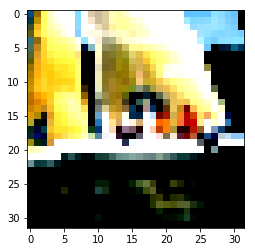

In [7]:
import matplotlib.pyplot as plt
import numpy as np
x = next(iter(train_data))

def show(img):
  img = img.numpy()
  plt.imshow(np.transpose(img,(1,2,0)))
  
print(x[0].shape)
grid = torchvision.utils.make_grid(x[0],nrow=10,padding=100)

show(grid)
show(x[0])

参数

In [0]:
BATCH_SIZE = 64

train_data_it = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
valid_data_it = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_data_it = data.DataLoader(test_data, batch_size = BATCH_SIZE)


定义Model LeNet

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(5*5*16 , 120)
    self.fc2 = nn.Linear(120 , 84)
    self.fc3 = nn.Linear(84 , 10)
   
  def forward(self,x):
    x = F.max_pool2d(F.relu(self.conv1(x)) , 2)
    x = F.max_pool2d(F.relu(self.conv2(x)) , 2)
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = LeNet().to(device)
optimizer = optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
print(model)

cuda
LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


计算准确率

In [0]:
def accuracy_cal(pred, y):
  # tensor.max选取 tensor中的最大值 
  # max(1)将 最大值的 index 作为结果输出
  prediction = pred.max(1)[1]
  correct = prediction.eq(y.view_as(prediction)).sum()
  acc = correct.float() / prediction.shape[0]
  return acc

In [0]:
def train(model, device , data , optimizer , loss_func):
  epoch_loss = 0
  epoch_acc = 0
  
  model.train()
  
  for (x,y) in data:
    
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    pred = model(x)
    loss = loss_func(pred, y)
    acc = accuracy_cal(pred,y)
    loss.backward()
    optimizer.step()
    
    # item()将单值tensor转换成标量
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(data), epoch_acc / len(data)

In [0]:
def test(model,device,data,loss_func):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  
  with torch.no_grad():
    for (x,y) in data:
      x = x.to(device)
      y = y.to(device)
      
      pred = model(x)
      loss = loss_func(pred,y)
      acc = accuracy_cal(pred,y)
      
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(data), epoch_acc / len(data)
      

In [17]:
EPOCH = 50
SAVE_DIR = 'models'
MODEL_SAVE_DIR = os.path.join(SAVE_DIR,'LeNet_cifar10.pt')

best_valid_loss = float('inf')


if not os.path.isdir(f'{SAVE_DIR}'):
  os.makedirs(f'{SAVE_DIR}')
  
for epoch in range(EPOCH):
  print('Epoch is ',epoch)
  train_loss , train_acc = train(model,device,train_data_it,optimizer,loss_func)
  valid_loss , valid_acc = test(model,device,valid_data_it,loss_func)
  
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),MODEL_SAVE_DIR)
  print('|EPOCH ',epoch,'|Train Loss is ',train_loss,'|Train Acc is ',train_acc,'|Valid Loss is ',valid_loss,'|Valid acc is ',valid_acc)

Epoch is  0
|EPOCH  0 |Train Loss is  1.1130904591726987 |Train Acc is  0.6037819602272727 |Valid Loss is  1.140095768095572 |Valid acc is  0.6042325949367089
Epoch is  1
|EPOCH  1 |Train Loss is  1.0980003606528044 |Train Acc is  0.6075328480113636 |Valid Loss is  1.1139715879778318 |Valid acc is  0.6089794303797469
Epoch is  2
|EPOCH  2 |Train Loss is  1.08692022675479 |Train Acc is  0.612060546875 |Valid Loss is  1.08654876524889 |Valid acc is  0.6214398734177216
Epoch is  3
|EPOCH  3 |Train Loss is  1.0775537708435545 |Train Acc is  0.6170321377840909 |Valid Loss is  1.1003138355061979 |Valid acc is  0.617879746835443
Epoch is  4
|EPOCH  4 |Train Loss is  1.062996600754559 |Train Acc is  0.6226029829545454 |Valid Loss is  1.1189618284189249 |Valid acc is  0.6137262658227848
Epoch is  5
|EPOCH  5 |Train Loss is  1.0485334133052013 |Train Acc is  0.6276411576704546 |Valid Loss is  1.054457101640822 |Valid acc is  0.6261867088607594
Epoch is  6
|EPOCH  6 |Train Loss is  1.041129821488

KeyboardInterrupt: ignored

In [16]:
model.load_state_dict(torch.load(MODEL_SAVE_DIR))
test_loss, test_acc = test(model,device,test_data_it,loss_func)
print('Test Loss is ',test_loss,'|Test ACC is ',test_acc)

Test Loss is  1.030051958788732 |Test ACC is  0.6329617834394905
